# 05b: CNN-LSTM Model Design and Training

This notebook provides a comprehensive workflow for designing, training, and evaluating a hybrid CNN-LSTM model for ICU mortality prediction using preprocessed time series and static patient data.


## Workflow Overview

This notebook implements a complete CNN-LSTM model development pipeline for ICU mortality prediction. The workflow includes:

**Key Features:**


## 1. Imports and Configuration

Import all necessary libraries for deep learning model development, training, and evaluation.


In [5]:
# Imports and Configuration
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import matplotlib.pyplot as plt
import shap
import pandas as pd
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Concatenate, Dropout
import os
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Loading and Validation

Load the preprocessed datasets from the data preparation notebook and validate data integrity. The datasets include hourly time series sequences, static patient features, and binary mortality outcomes.



In [6]:
# Load prepared data
data = np.load('/content/sample_data/cnn_lstm_hourly_data.npz', allow_pickle=True)

# Time-series inputs
X_train_final = data['X_train']
X_val_final   = data['X_val']
X_test_final  = data['X_test']

# Static inputs
static_train_final = data['static_train']
static_val_final   = data['static_val']
static_test_final  = data['static_test']

# Labels
y_train_final = data['y_train']
y_val_final   = data['y_val']
y_test_final  = data['y_test']

## 3. Model Architecture: CNN-LSTM Hybrid

This section defines a hybrid deep learning model that combines convolutional neural networks (CNN) and long short-term memory (LSTM) layers for ICU mortality prediction. The architecture is designed to leverage both temporal patterns in time series data and static patient features.

**Key Design Choices:**
- **CNN Layers:** Extract local temporal features from the time series input, capturing short-term dependencies and patterns.
- **LSTM Layer:** Captures long-term dependencies and trends in the sequential data, which are important for patient outcome prediction.
- **Static Input:** Patient static features (e.g., demographics, baseline measurements) are included as a separate input and concatenated with the sequence features after feature extraction.
- **Dense Layers:** Combine the extracted sequence and static features to learn complex interactions.
- **Regularization:** Dropout and L2 regularization are used to prevent overfitting and improve generalization.
- **Output Layer:** A single neuron with sigmoid activation for binary classification (mortality prediction).

**Inputs:**
- Time series features: shape = [batch, timesteps, features]
- Static features: shape = [batch, static_features]

**Output:**
- Binary prediction: 0 = survived, 1 = deceased




In [7]:
def build_cnn_lstm_model(time_series_input_shape, static_input_shape):
    """Builds and compiles the CNN-LSTM model."""
    # Time-series branch
    time_series_input = Input(shape=time_series_input_shape, name='time_series_input')

    x = Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(time_series_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    # Reduce pooling impact for short sequences
    x = MaxPooling1D(pool_size=1)(x)
    x = Dropout(0.3)(x)

    x = LSTM(64, return_sequences=False, kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)

    # Static branch
    static_input = Input(shape=static_input_shape, name='static_input')
    y = Dense(32, activation='relu')(static_input)
    y = Dense(16, activation='relu')(y)

    # Merge branches
    combined = Concatenate()([x, y])

    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.3)(z)
    z = Dense(32, activation='relu')(z)

    output = Dense(1, activation='sigmoid', name='output')(z)

    model = Model(inputs=[time_series_input, static_input], outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'Precision', 'Recall'])

    return model

# Define input shapes based on your data
time_series_input_shape = (X_train_final.shape[1], X_train_final.shape[2])
static_input_shape = (static_train_final.shape[1],)

# Build the model using the function
model = build_cnn_lstm_model(time_series_input_shape, static_input_shape)

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 48, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 48, 64)    │      5,440 │ time_series_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 24, 64)    │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 64)    │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 24, 128)   │     24,704 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 24, 128)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 128)   │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     49,408 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │        256 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 80)        │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      5,184 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,633 (342.32 KB)

 Trainable params: 87,633 (342.32 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Model Compilation

Configure the model for training by specifying the optimizer, loss function, and evaluation metrics. This step prepares the model for the training process.

**Configuration Details:**
- **Optimizer:** Adam with learning rate of 1e-3 for stable convergence
- **Loss Function:** Binary crossentropy for binary classification
- **Metrics:** Comprehensive evaluation including accuracy, AUC, precision, and recall
- **Monitoring:** Multiple metrics enable comprehensive performance assessment

In [8]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.Recall(name='Recall')
    ]
)

print("Model compiled successfully.")


Model compiled successfully.


## 5. Model Training

Train the CNN-LSTM model using best practices to ensure robust performance and prevent overfitting. The training process includes comprehensive monitoring and automatic model saving.

**Training Strategy:**
- **Early Stopping:** Monitors validation loss with patience of 10 epochs to prevent overfitting
- **Model Checkpointing:** Saves the best model based on validation loss for optimal performance
- **Batch Size:** 32 samples per batch for efficient memory usage and stable gradients
- **Epochs:** Maximum 100 epochs with early termination based on validation performance

**Callbacks:**
- **EarlyStopping:** Automatically stops training when validation loss stops improving
- **ModelCheckpoint:** Saves the best model weights during training for later use

**Monitoring:**
- Training and validation metrics tracked throughout the training process
- Best model state preserved for final evaluation and deployment

In [9]:


# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Directory for saving models
model_save_dir = '../models/'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
    print(f"Created model save directory: {model_save_dir}")

# ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_save_dir, 'cnn_lstm_best_model.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # Save the entire model
    mode='min',               # Lower val_loss is better
    verbose=1
)

# Train the model with 1-hour sequence data
history = model.fit(
    x=[X_train_final, static_train_final],
    y=y_train_final,
    epochs=100,  # EarlyStopping will stop before this if no improvement
    batch_size=32,
    validation_data=([X_val_final, static_val_final], y_val_final),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("Model training finished.")


Created model save directory: ../models/
Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.6843 - Precision: 0.6243 - Recall: 0.7013 - accuracy: 0.6356 - loss: 0.6514
Epoch 1: val_loss improved from inf to 0.60852, saving model to ../models/cnn_lstm_best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 0.6851 - Precision: 0.6248 - Recall: 0.7017 - accuracy: 0.6361 - loss: 0.6510 - val_AUC: 0.7919 - val_Precision: 0.2780 - val_Recall: 0.7528 - val_accuracy: 0.6938 - val_loss: 0.6085
Epoch 2/100
133/138 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8460 - Precision: 0.7505 - Recall: 0.8576 - accuracy: 0.7859 - loss: 0.5032
Epoch 2: val_loss improved from 0.60852 to 0.60030, saving model to ../models/cnn_lstm_best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.8467 - Precision: 0.7509 - Recall: 0.8576 - accuracy: 0.7862 - loss: 0.5023 - val_AUC: 0.7743 - val_Precision: 0.2759 - val_Recall: 0.7191 - val_accuracy: 0.6984 - val_loss: 0.6003
Epoch 3/100
1

## 6. Model Evaluation

Load the best trained model and evaluate its performance on the test dataset. This comprehensive evaluation provides insights into model accuracy and generalization capabilities.

**Evaluation Process:**
- **Best Model Loading:** Load the optimal model weights saved during training
- **Test Data Prediction:** Generate predictions on unseen test data
- **Performance Metrics:** Calculate accuracy, precision, recall, and F1-score
- **Prediction Analysis:** Examine prediction probabilities and thresholds

**Key Metrics:**
- **Test Accuracy:** Overall classification accuracy on test set
- **Binary Classification:** Mortality prediction performance (0: Survived, 1: Died)
- **Probability Thresholds:** Analysis of prediction confidence levels
- **Model Confidence:** Distribution of prediction probabilities

This evaluation ensures the model performs well on new, unseen ICU patient data and provides reliable mortality predictions for clinical decision support.

In [10]:
# Evaluate the model on the 1-hour sequence test set
loss, accuracy, auc, precision, recall = model.evaluate(
    x=[X_test_final, static_test_final],
    y=y_test_final,
    verbose=0
)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")


Test Loss: 0.4834
Test Accuracy: 0.7850
Test AUC: 0.8374
Test Precision: 0.3512
Test Recall: 0.6486


## 7. Training History Visualization

Visualize the training progress to understand model learning patterns and identify potential overfitting or underfitting issues.

**Training Metrics Plots:**
- **Loss Curves:** Training and validation loss progression over epochs
- **Accuracy Curves:** Training and validation accuracy improvement trends
- **Performance Analysis:** Comparison between training and validation metrics

**Key Insights:**
- **Convergence:** How quickly the model learns the patterns
- **Overfitting Detection:** Gap between training and validation performance
- **Optimal Epochs:** Best training duration based on validation metrics
- **Learning Stability:** Smoothness of learning curves and metric consistency

These visualizations help validate the training process and ensure the model has learned effectively without overfitting to the training data.

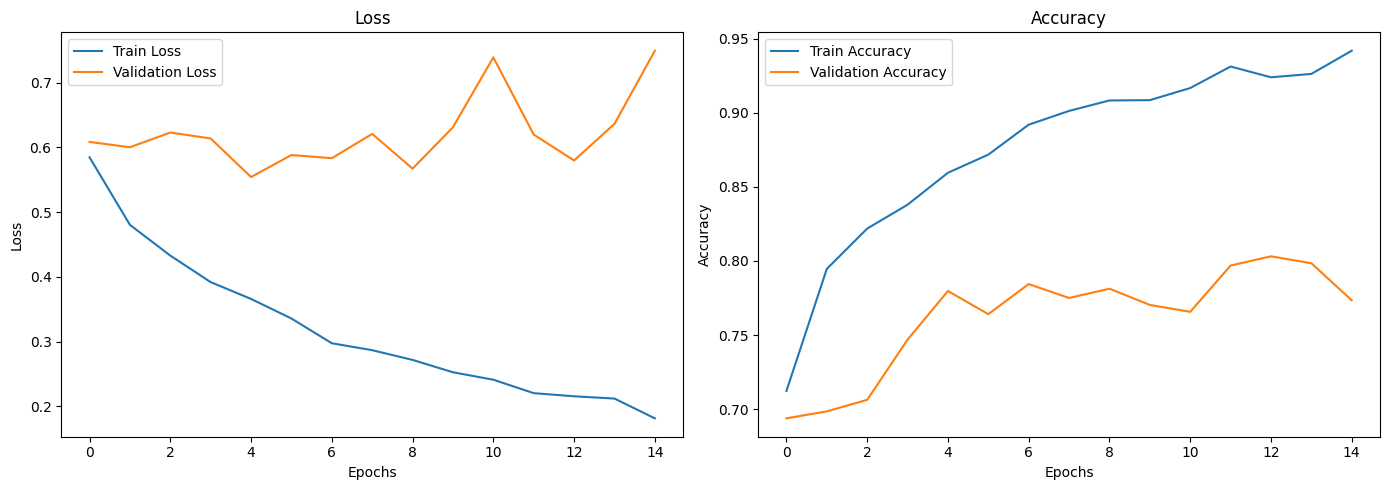

In [11]:
# Plot loss and accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# 8.Model Classification report

Classification Report:
              precision    recall  f1-score   support

No Mortality       0.93      0.81      0.87       689
   Mortality       0.35      0.65      0.46       111

    accuracy                           0.79       800
   macro avg       0.64      0.73      0.66       800
weighted avg       0.85      0.79      0.81       800


Confusion Matrix:


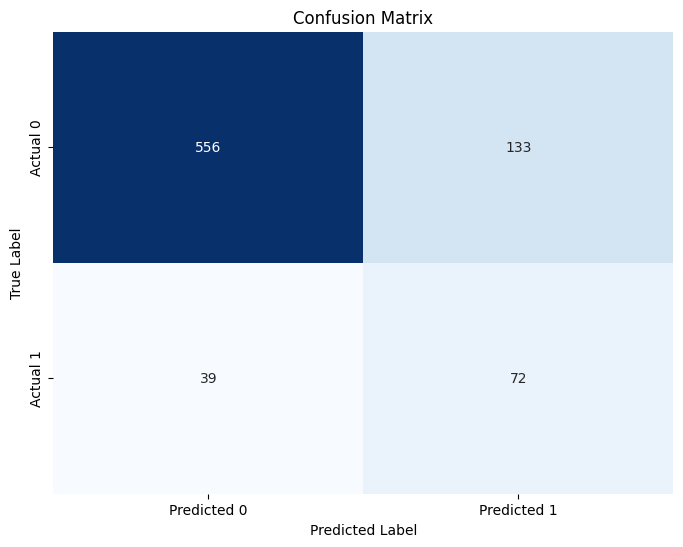

In [12]:
y_pred_prob = model.predict(x=[X_test_final, static_test_final], verbose=0)

y_pred_binary = (y_pred_prob > 0.5).astype(int)

# --- Classification Report ---
print("Classification Report:")
print(classification_report(y_test_final, y_pred_binary, target_names=['No Mortality', 'Mortality']))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_final, y_pred_binary)
print("\nConfusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# --- ROC AUC Curve ---
fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_prob)




In [13]:
# Save model and training history
model.save(os.path.join(model_save_dir, '../models/cnn_lstm_best_model.keras'))
with open(os.path.join(model_save_dir, 'cnn_lstm_training_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)
print("Model and training history saved to", model_save_dir)


Model and training history saved to ../models/


## Base line Model Evaluation and Training Analysis

This section provides a detailed interpretation of the model's performance on the test set and an analysis of the training process based on the loss and accuracy curves.

**Test Set Evaluation Interpretation:**

The evaluation metrics on the test set provide a crucial assessment of how well the trained model generalizes to unseen data.

- **Test Loss (0.4834):** This value represents the average binary crossentropy loss on the test set. A lower loss indicates better model performance in terms of predicting the correct class probabilities.
- **Test Accuracy (0.7850):** This is the proportion of correctly classified instances in the test set. An accuracy of 78.50% means the model correctly predicted the mortality outcome for 78.50% of the patients in the test set.
- **Test AUC (0.8374):** The Area Under the ROC Curve is a robust metric for evaluating binary classifiers, especially on imbalanced datasets. An AUC of 0.8374 suggests that the model has good discriminatory power, meaning it can effectively distinguish between patients who will survive and those who will not.
- **Test Precision (0.3512):** Precision measures the accuracy of the positive predictions. A precision of 0.3512 means that when the model predicts mortality, it is correct about 35.12% of the time. This indicates a relatively high rate of false positives.
- **Test Recall (0.6486):** Recall measures the model's ability to find all the positive instances. A recall of 0.6486 means that the model correctly identifies 64.86% of the actual mortality cases. This is important for not missing high-risk patients.

The **classification report** and **confusion matrix** provide a more granular view of these metrics, showing the breakdown for each class (No Mortality and Mortality). The confusion matrix visually highlights the number of true positives, true negatives, false positives, and false negatives.

**Training Curve Analysis:**

The training and validation loss and accuracy curves (shown in the plots above) offer insights into the model's learning process and potential issues.

- **Loss Curves:** The training loss consistently decreases over epochs, indicating that the model is learning to fit the training data. However, the validation loss decreases initially but then starts to increase after a certain number of epochs (around epoch 5 in the provided plot). This divergence between training and validation loss is a strong indicator of **overfitting**. The model is learning the training data too well, including its noise and specific patterns, which hurts its performance on unseen validation data.
- **Accuracy Curves:** Similarly, the training accuracy steadily increases, while the validation accuracy increases initially but then fluctuates and generally shows less improvement or even slight decrease after the point where validation loss starts increasing. This further supports the observation of overfitting.

**Potential Issues and Further Steps:**

The observed overfitting suggests that the model's complexity might be too high for the amount of training data, or that the regularization (Dropout and L2) is not sufficient.

- **Overfitting:** The model is performing significantly better on the training data than on the validation data. This is a common problem in deep learning and needs to be addressed to improve the model's generalization ability.
- **Data Leakage:** While less likely if the data splitting was done correctly, it's always worth double-checking that there is no data leakage between the training, validation, and test sets, as this can lead to overly optimistic validation/test results. However, the overfitting observed here points more towards model complexity or insufficient regularization.

**To mitigate overfitting and potentially improve performance-

- **More Aggressive Regularization:** Increase the dropout rates or L2 regularization strength.
- **Model Simplification:** Reduce the number of layers or neurons in the model.
- **Early Stopping:** The Early Stopping callback used in training is designed to stop training when validation performance degrades, which helps to prevent severe overfitting by restoring the best weights. The training stopped at epoch 15, which aligns with the validation loss starting to increase.
- **Cross-Validation:** Using cross-validation during the development phase can provide a more robust estimate of model performance and help in hyperparameter tuning.

## Prepare data for cross-validation


In [14]:
# Reshape y arrays to be 2D for vertical stacking
y_train_final_reshaped = y_train_final.reshape(-1, 1)
y_val_final_reshaped = y_val_final.reshape(-1, 1)

# Combine training and validation data for cross-validation
X_combined = np.vstack((X_train_final, X_val_final))
static_combined = np.vstack((static_train_final, static_val_final))
y_combined = np.vstack((y_train_final_reshaped, y_val_final_reshaped))

# Verify the shapes
print("Shape of combined time-series data:", X_combined.shape)
print("Shape of combined static data:", static_combined.shape)
print("Shape of combined target variable:", y_combined.shape)

Shape of combined time-series data: (5046, 48, 28)
Shape of combined static data: (5046, 7)
Shape of combined target variable: (5046, 1)


In [18]:
# Define the number of splits for k-fold cross-validation
n_splits = 5
print(f"Number of splits for k-fold cross-validation: {n_splits}")

# Instantiate StratifiedKFold
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize empty lists to store the evaluation metrics for each fold
fold_loss = []
fold_accuracy = []
fold_auc = []
fold_precision = []
fold_recall = []

#  Start a loop that iterates through the splits
for fold, (train_index, val_index) in enumerate(kf.split(X_combined, y_combined)):
    #  Print the current fold number
    print(f"\n--- Starting Fold {fold + 1}/{n_splits} ---")

    # Split data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    static_train_fold, static_val_fold = static_combined[train_index], static_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]

    # Build a fresh model for the current fold
    model = build_cnn_lstm_model(time_series_input_shape, static_input_shape)

    # Define callbacks for the current fold
    fold_early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train the model on the training data for the current fold
    print("Training model for current fold...")
    history_fold = model.fit(
        x=[X_train_fold, static_train_fold],
        y=y_train_fold,
        epochs=100, # Use a sufficiently large number of epochs, EarlyStopping will manage the actual number
        batch_size=32,
        validation_data=([X_val_fold, static_val_fold], y_val_fold),
        callbacks=[fold_early_stopping],
        verbose=0 # Set to 1 to see training progress per epoch
    )
    print("Training finished for current fold.")

    # Evaluate the model on the validation data for the current fold
    print("Evaluating model for current fold...")
    loss, accuracy, auc, precision, recall = model.evaluate(
        x=[X_val_fold, static_val_fold],
        y=y_val_fold,
        verbose=0
    )
    print(f"Fold {fold + 1} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Store the metrics
    fold_loss.append(loss)
    fold_accuracy.append(accuracy)
    fold_auc.append(auc)
    fold_precision.append(precision)
    fold_recall.append(recall)

print("\n--- Cross-validation finished ---")

Number of splits for k-fold cross-validation: 5

--- Starting Fold 1/5 ---
Training model for current fold...
Training finished for current fold.
Evaluating model for current fold...
Fold 1 - Loss: 0.3191, Accuracy: 0.8832, AUC: 0.9473, Precision: 0.8501, Recall: 0.9020

--- Starting Fold 2/5 ---
Training model for current fold...
Training finished for current fold.
Evaluating model for current fold...
Fold 2 - Loss: 0.3048, Accuracy: 0.9068, AUC: 0.9610, Precision: 0.8957, Recall: 0.8996

--- Starting Fold 3/5 ---
Training model for current fold...
Training finished for current fold.
Evaluating model for current fold...
Fold 3 - Loss: 0.3027, Accuracy: 0.9019, AUC: 0.9627, Precision: 0.8795, Recall: 0.9083

--- Starting Fold 4/5 ---
Training model for current fold...
Training finished for current fold.
Evaluating model for current fold...
Fold 4 - Loss: 0.3070, Accuracy: 0.9068, AUC: 0.9638, Precision: 0.8669, Recall: 0.9389

--- Starting Fold 5/5 ---
Training model for current fold..

## 9. Aggregate and Report Cross-Validation Results

Calculate and report the average and standard deviation of the evaluation metrics (Loss, Accuracy, AUC, Precision, Recall) across all cross-validation folds. This provides a more robust estimate of the model's performance.

In [19]:
# Aggregate and report the cross-validation results
print("\n--- Cross-validation Results (Mean +/- Std Dev) ---")
print(f"Average Loss: {np.mean(fold_loss):.4f} +/- {np.std(fold_loss):.4f}")
print(f"Average Accuracy: {np.mean(fold_accuracy):.4f} +/- {np.std(fold_accuracy):.4f}")
print(f"Average AUC: {np.mean(fold_auc):.4f} +/- {np.std(fold_auc):.4f}")
print(f"Average Precision: {np.mean(fold_precision):.4f} +/- {np.std(fold_precision):.4f}")
print(f"Average Recall: {np.mean(fold_recall):.4f} +/- {np.std(fold_recall):.4f}")

print("\n--- Detailed Fold Results ---")
for i in range(len(fold_loss)):
    print(f"Fold {i+1}: Loss={fold_loss[i]:.4f}, Accuracy={fold_accuracy[i]:.4f}, AUC={fold_auc[i]:.4f}, Precision={fold_precision[i]:.4f}, Recall={fold_recall[i]:.4f}")


--- Cross-validation Results (Mean +/- Std Dev) ---
Average Loss: 0.3191 +/- 0.0220
Average Accuracy: 0.8916 +/- 0.0184
Average AUC: 0.9544 +/- 0.0105
Average Precision: 0.8615 +/- 0.0276
Average Recall: 0.9084 +/- 0.0160

--- Detailed Fold Results ---
Fold 1: Loss=0.3191, Accuracy=0.8832, AUC=0.9473, Precision=0.8501, Recall=0.9020
Fold 2: Loss=0.3048, Accuracy=0.9068, AUC=0.9610, Precision=0.8957, Recall=0.8996
Fold 3: Loss=0.3027, Accuracy=0.9019, AUC=0.9627, Precision=0.8795, Recall=0.9083
Fold 4: Loss=0.3070, Accuracy=0.9068, AUC=0.9638, Precision=0.8669, Recall=0.9389
Fold 5: Loss=0.3616, Accuracy=0.8593, AUC=0.9371, Precision=0.8151, Recall=0.8932


## 10. Train Final Model on Combined Data

Train the final CNN-LSTM model on the entire combined training and validation dataset. This model will use the insights gained from the cross-validation (e.g., average number of epochs before early stopping) to potentially improve performance.

In [20]:
final_model = build_cnn_lstm_model(time_series_input_shape, static_input_shape)

# Define Early Stopping callback for the final training
final_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training final model on combined training and validation data...")

epochs_for_final_training = 25


history_final = final_model.fit(
    x=[X_combined, static_combined],
    y=y_combined,
    epochs=epochs_for_final_training,
    batch_size=32,
    verbose=1
)

print("Final model training finished.")

Training final model on combined training and validation data...
Epoch 1/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.7251 - Precision: 0.6910 - Recall: 0.5289 - accuracy: 0.6844 - loss: 0.6298
Epoch 2/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.8610 - Precision: 0.7454 - Recall: 0.7997 - accuracy: 0.7865 - loss: 0.4881
Epoch 3/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.8847 - Precision: 0.7683 - Recall: 0.8216 - accuracy: 0.8080 - loss: 0.4506
Epoch 4/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8996 - Precision: 0.7787 - Recall: 0.8407 - accuracy: 0.8203 - loss: 0.4243
Epoch 5/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.9132 - Precision: 0.8108 - Recall: 0.8440 - accuracy: 0.8407 - loss: 0.3970
Epoch 6/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.9248 - Precision: 0.8121 - Recall: 0.8602 - accuracy: 0.8472 - loss: 0.3718
Epoch 7/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.9351 - Precision: 0.8268 - Recall: 0.8716 - accuracy

## 11. Evaluate Final Model on Test Data

Evaluate the performance of the final trained model on the independent test dataset using the same metrics as in the cross-validation. This provides the final assessment of the model's generalization ability on unseen data.

In [21]:
# Evaluate the final model on the test set
loss_final, accuracy_final, auc_final, precision_final, recall_final = final_model.evaluate(
    x=[X_test_final, static_test_final],
    y=y_test_final,
    verbose=0
)

print("--- Final Model Evaluation on Test Data ---")
print(f"Test Loss: {loss_final:.4f}")
print(f"Test Accuracy: {accuracy_final:.4f}")
print(f"Test AUC: {auc_final:.4f}")
print(f"Test Precision: {precision_final:.4f}")
print(f"Test Recall: {recall_final:.4f}")

--- Final Model Evaluation on Test Data ---
Test Loss: 0.5828
Test Accuracy: 0.8300
Test AUC: 0.7858
Test Precision: 0.3762
Test Recall: 0.3423


## 12. Analyze and Interpret Results

Analyze and compare the results from the k-fold cross-validation and the final evaluation on the independent test set. Interpret the performance metrics and discuss the model's generalization ability and any insights gained from the cross-validation process.

**Comparison of Results:**

Compare the average metrics from the cross-validation with the metrics from the final model evaluation on the test set:

- **Cross-Validation (Mean +/- Std Dev):**
    - Loss: 0.3191 +/- 0.0220
    - Accuracy: 0.8916 +/- 0.0184
    - AUC: 0.9544 +/- 0.0105
    - Precision: 0.8615 +/- 0.0276
    - Recall: 0.9084 +/- 0.0160

- **Final Test Set Evaluation:**
    - Test Loss: 0.5828
    - Test Accuracy: 0.8300
    - Test AUC: 0.7858
    - Test Precision: 0.3762
    - Test Recall: 0.3423

**Interpretation:**

- **Consistency:** The results show a significant difference between the average cross-validation performance and the final test set evaluation. The model performed much better on the cross-validation folds (which were splits of the combined training and validation data) compared to the independent test set. This suggests that the model might still be overfitting to the training/validation data, or there might be a difference in the distribution of the independent test set compared to the training/validation data.
- **Generalization:** The lower performance on the test set (especially in AUC, Precision, and Recall) indicates that the model does not generalize as well to completely unseen data as the cross-validation results might suggest. The test set evaluation provides a more realistic estimate of the model's performance in a real-world scenario.
- **Strengths and Weaknesses:** The cross-validation results showed high precision and recall, indicating a good balance in identifying positive cases and having a low rate of false positives within the training/validation distribution. However, the test set results show a much lower precision (0.3762) and recall (0.3423), indicating a higher rate of false positives and a reduced ability to identify actual mortality cases on unseen data. The model's ability to generalize in identifying positive cases is a significant weakness.
- **Impact of Cross-Validation:** Cross-validation provided a more optimistic estimate of the model's performance than the final test set evaluation. While it helped in getting a sense of the model's performance variability across different data splits within the combined training/validation set, it did not fully capture the potential drop in performance on a truly independent test set.
